 <h1 align="center">Find a car Park using CNN</h1>

 <h3 align="center">Authors: Noa Aizer & Ido Shapira & Shay Leyzerovich</h3>   

In this project we propose to develop a model for identifying whether there is free space in theparking lot image, or whether the parking is full using CNN.

## Code & Explanations:

### Import all the necessary libraries:
We have used Python libraries:
- tensorflow v1
- sklearn

In [1]:
import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
# import tensorflow as tf
import cv2
import os
from tqdm import tqdm
import numpy as np
import random as rn

from __future__ import division, print_function, absolute_import

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn import metrics


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

rs = 42 # random seed

### fix random seed:

In [2]:
np.random.seed(rs)
rn.seed(rs)
tf.set_random_seed(rs)

### import the data:

In [3]:
X = []
Z = []
IMG_SIZE=160

FREE_DIR='/home/ido/Desktop/Find-a-Car-Park/data/Free'
FULL_DIR='/home/ido/Desktop/Find-a-Car-Park/data/Full'

In [4]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR,img)
        img = plt.imread(path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        np_img=np.asarray(img)
        X.append(np_img)
        Z.append(str(label))

In [5]:
# make 'Full' data
make_train_data('Full',FULL_DIR)
print(len(X))

100%|██████████| 2195/2195 [00:20<00:00, 105.07it/s]

2195


In [6]:
# make 'Free' data
make_train_data('Free',FREE_DIR)
print(len(X))

100%|██████████| 1067/1067 [00:09<00:00, 109.37it/s]

3262


### The description of the data:

1. Number of instances: 722

2. Number of attributes: 150 * 150 * 3 = 67500

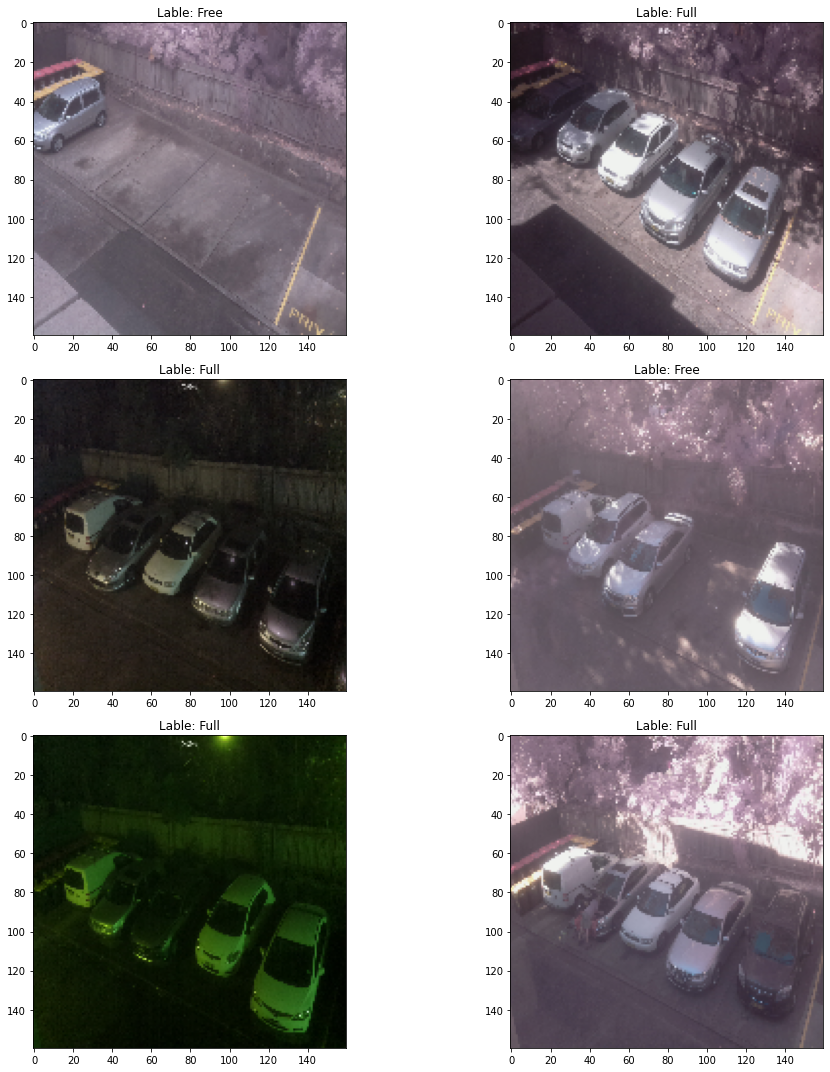

In [7]:
# check some image
fig,ax=plt.subplots(3,2)
fig.set_size_inches(15,15)
for i in range(3):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Lable: '+Z[l])
        
plt.tight_layout()

### Label encoding of the target:
'Full' = 0

'Free' = 1

In [8]:
Y = np.array(Z)
Y = np.where(Y=='Full', 0, Y)
Y = np.where(Y=='Free', 1, Y)
Y = Y.astype('int32')

### normalization and flatten the images:

In [9]:
X = np.array([cv2.normalize(X[i], None, 0, 255, cv2.NORM_MINMAX) for i in range(len(X))]) # normalization
X=np.array(X)/255
X = X.flatten().reshape(len(X), (IMG_SIZE ** 2) * 3) # 3 is because it is RGB image 
# X = X.flatten().reshape(len(X), (IMG_SIZE ** 2)) 

#### our dataset:

In [10]:
df = pd.DataFrame(data=X)
df

,0,1,2,3,4,5,6,7,8,9,...,76790,76791,76792,76793,76794,76795,76796,76797,76798,76799
0,0.298039,0.168627,0.243137,0.270588,0.164706,0.219608,0.266667,0.160784,0.203922,0.270588,...,0.952941,0.917647,0.933333,0.960784,0.219608,0.203922,0.282353,0.160784,0.141176,0.207843
1,0.466667,0.337255,0.368627,0.501961,0.368627,0.400000,0.494118,0.337255,0.384314,0.478431,...,0.219608,0.372549,0.243137,0.215686,0.341176,0.207843,0.196078,0.321569,0.192157,0.184314
2,0.313725,0.200000,0.258824,0.309804,0.219608,0.247059,0.266667,0.156863,0.207843,0.262745,...,0.360784,0.290196,0.247059,0.152941,0.215686,0.172549,0.086275,0.333333,0.266667,0.215686
3,0.560784,0.360784,0.454902,0.635294,0.419608,0.525490,0.698039,0.458824,0.588235,0.596078,...,0.243137,0.215686,0.149020,0.196078,0.164706,0.094118,0.149020,0.247059,0.168627,0.207843
4,0.227451,0.184314,0.239216,0.207843,0.164706,0.239216,0.223529,0.188235,0.239216,0.215686,...,0.172549,0.454902,0.533333,0.537255,0.623529,0.796078,0.796078,0.772549,0.945098,0.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,0.541176,0.384314,0.482353,0.568627,0.400000,0.490196,0.533333,0.376471,0.470588,0.541176,...,0.368627,0.368627,0.301961,0.356863,0.372549,0.301961,0.352941,0.368627,0.282353,0.317647
3258,0.278431,0.168627,0.207843,0.274510,0.168627,0.192157,0.419608,0.313725,0.329412,0.258824,...,0.180392,0.192157,0.192157,0.243137,0.223529,0.223529,0.278431,0.254902,0.243137,0.309804
3259,0.541176,0.403922,0.450980,0.552941,0.407843,0.462745,0.517647,0.368627,0.423529,0.513725,...,0.290196,0.294118,0.215686,0.266667,0.258824,0.172549,0.235294,0.203922,0.109804,0.160784
3260,0.388235,0.274510,0.356863,0.466667,0.333333,0.403922,0.458824,0.329412,0.403922,0.466667,...,0.333333,0.345098,0.290196,0.309804,0.298039,0.254902,0.266667,0.266667,0.219608,0.223529


We can see that the size of an image is 150 \* 150 \* 3 = 67500 that later it would be our featrues in our models.

In [11]:
X.shape

(3262, 76800)

### Train-Test Split:

In [12]:
# separate data
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.20,random_state=rs, shuffle=True)

freqs = pd.DataFrame({"Training dataset": [(y_train == 1).sum(),(y_train == 0).sum()],
                      "Test dataset": [(y_test == 1).sum(),(y_test == 0).sum()],
                      "Total": [(y_train == 1).sum()+(y_test == 1).sum(),(y_train == 0).sum()+(y_test == 0).sum()]},
                     index=["Free", "Full"])
freqs[["Training dataset", "Test dataset", "Total"]]

,Training dataset,Test dataset,Total
Free,863,204,1067
Full,1746,449,2195


We'll build a classifier with two classes: "full",
so we create the according labels.

In [13]:
labels_train = (np.arange(2) == y_train[:,None]).astype(np.float32)
labels_test = (np.arange(2) == y_test[:,None]).astype(np.float32)

In [14]:
def statistics(confusion):
    TP = sess.run(confusion[1, 1])
    TN = sess.run(confusion[0, 0])
    FP = sess.run(confusion[0, 1])
    FN = sess.run(confusion[1, 0])
    print('True Positives (TP):',TP)
    print('True Negatives (TN):',TN)
    print('False Positives (FP):',FP)
    print('False Negarives (FN):',FN)
    print('Classification Accuracy:',(TP + TN) / float(TP + TN + FP + FN))
    precision = TP / float(TP + FP)
    print('Precision:',precision)
    recall = TP / float(TP + FN)
    print('Recall:', recall)
    print('f-score:', 2 * precision * recall / (precision + recall))

### Begin building the CNN model using tensorflow:

1. Define the requires training parameters:
    - learning rate
    - batch_size
    - number of iteration

In [83]:
learning_rate = 0.001
num_steps = 440
batch_size = 128
display_step = 10
channels = 3 # RGB

2. Define the requires network parameters
    - input size
    - classes number
    - dropout

In [84]:
num_input = IMG_SIZE * IMG_SIZE * channels
num_classes = 2
dropout = 0.8 # Dropout, probability to keep units

3. Define placeholders

In [85]:
tf.compat.v1.disable_eager_execution()

X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

4. Define the structure of the net.

In [86]:

weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, channels, 32])),
    # 3x3 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([3, 3, 32 , 64])),
    # 3x3 conv, 32 inputs, 64 outputs
    #'wc3': tf.Variable(tf.random_normal([3, 3, 64 , 96])),
    # fully connected, 10*10*96 inputs, 512 outputs
    'wd1': tf.Variable(tf.random_normal([40*40*64 , 1024])),
    # 1024 inputs, 2 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, num_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    #'bc3': tf.Variable(tf.random_normal([96])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

5. Create some wrappers for simplicity and the CNN model

In [87]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

- Create model:

In [88]:
def conv_net(x, weights, biases, dropout):
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x, shape=[-1, IMG_SIZE, IMG_SIZE, channels])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (sub-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (sub-sampling)
    conv2 = maxpool2d(conv2, k=2)
    
#     # Convolution Layer
#     conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
#     # Max Pooling (sub-sampling)
#     conv3 = maxpool2d(conv3, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

Construct model

In [89]:
logits = conv_net(X, weights, biases, keep_prob)
prediction = tf.nn.softmax(logits)

6. Loss function and optimizer (Back Propagation):

In [90]:
# loss = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=logits, labels=Y, pos_weight=3))
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

7. Evaluate model

In [91]:
predict = tf.argmax(logits, axis=1)
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

8. Open session and initialize the variables

In [92]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

### End of the definition of the model framework

In [93]:
# Define the variable that saves the result
loss_trace = []
train_acc = []
test_acc = []

### Start training the feed-forward neural network model:

In [94]:
for step in range(1, num_steps+1):        
    # Generate random batch index
    batch_index = np.random.choice(len(X_train), size=batch_size)
    batch_x = X_train[batch_index]
    batch_y = labels_train[batch_index]

    # Run optimization op (backprop)
    sess.run(optimizer, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout})

    # Calculate batch loss and accuracy
    loss_temp, temp_train_acc = sess.run([loss, accuracy], feed_dict={X: batch_x, Y: batch_y, keep_prob: 1.0})
    temp_test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: labels_test, keep_prob: 1.0})
    if step % display_step == 0 or step == 1:
        print("Step " + str(step) + ", Loss= " + \
              "{:.4f}".format(loss_temp) + ", Training Accuracy= " + \
              "{:.3f}".format(temp_train_acc) + ", Test Accuracy= " + \
             "{:.3f}".format(temp_test_acc))

    # recode the result
    loss_trace.append(loss_temp)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)


print("Optimization Finished!")

# Calculate accuracy
print("Testing Accuracy:", \
    sess.run(accuracy, feed_dict={X: X_test,
                                  Y: labels_test,
                                  keep_prob: 1.0}))

Step 1, Loss= 143368.7656, Training Accuracy= 0.438, Test Accuracy= 0.312
Step 10, Loss= 35572.5352, Training Accuracy= 0.719, Test Accuracy= 0.732
Step 20, Loss= 20809.5234, Training Accuracy= 0.773, Test Accuracy= 0.783
Step 30, Loss= 14389.7031, Training Accuracy= 0.773, Test Accuracy= 0.824
Step 40, Loss= 7380.9180, Training Accuracy= 0.867, Test Accuracy= 0.839
Step 50, Loss= 4785.9756, Training Accuracy= 0.906, Test Accuracy= 0.809
Step 60, Loss= 5141.4932, Training Accuracy= 0.883, Test Accuracy= 0.881
Step 70, Loss= 6839.3911, Training Accuracy= 0.883, Test Accuracy= 0.873
Step 80, Loss= 1514.0216, Training Accuracy= 0.945, Test Accuracy= 0.891
Step 90, Loss= 1821.5341, Training Accuracy= 0.930, Test Accuracy= 0.894
Step 100, Loss= 1871.1790, Training Accuracy= 0.953, Test Accuracy= 0.911
Step 110, Loss= 1744.6630, Training Accuracy= 0.969, Test Accuracy= 0.923
Step 120, Loss= 1121.2007, Training Accuracy= 0.984, Test Accuracy= 0.936
Step 130, Loss= 1762.5992, Training Accuracy

### Visualization of the loss function results:

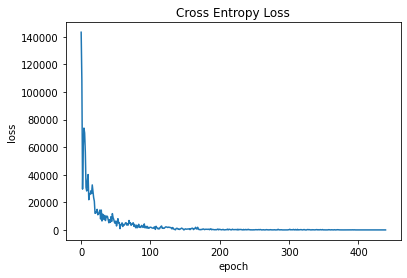

In [95]:
plt.plot(loss_trace)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

We can see that the loss value reduce during the train, there's a graph that shows that.

In [96]:
# The model prediction
y_predictions = sess.run(predict, feed_dict={X: X_test, Y: labels_test, keep_prob: 1.0})

In [97]:
tf.compat.v1.math.confusion_matrix
confusion = tf.math.confusion_matrix(y_test, y_predictions, num_classes=2, dtype=tf.int32)
print(sess.run(confusion))

[[444   5]
 [  7 197]]


In [98]:
statistics(confusion)

True Positives (TP): 197
True Negatives (TN): 444
False Positives (FP): 5
False Negarives (FN): 7
Classification Accuracy: 0.9816232771822359
Precision: 0.9752475247524752
Recall: 0.9656862745098039
f-score: 0.9704433497536946


The results indicate that the model could not recognize a lot of free parking spot because of the recall but when it did the precision was high.

In [99]:
sess.close()